# Sentiment Analysis - The Twitter US Airlines Dataset

This project revolves around a dataset of tweets redirected to all the major US airlines companies during February 2015. The idea is to try to develop a Bayesian Network around this dataset. The notebook will have 5 major sections:

__Data Preprocessing:__ In this section we prepare the dataset to be examined. We'll delete columns, remap values from continuous to discrete...

__Presentation of the Model:__ I will explain the structure of the network and why I built it in the way it's built.

__Computation of the Probability Tables:__ Since we have a dataset, a lot of the probability tables can be computed on the dataset itself. This process cannot be applied on every node of the network since I couldn't find some data (for example, the probability of a strike happening).

__Creation of the model:__ Creation of the Bayesian network with the pgmpy library.

__Queries:__ I'll perform some queries on the model and there will also be a small discussion on sampling. Also, I will try to use the model as a naive classifier.

The Table of Contents will help navigating through these sections.

# Table of Contents

* [1. Data Preprocessing](#DP)
    * [1.1. The Dataset and the columns we'll need](#DP-1)
    * [1.2. The negativereason column](#DP-2)
    * [1.3. The retweet column](#DP-3)
    * [1.4. The tweet_created column](#DP-4)
    * [1.5. The tweet_length column](#DP-5)
    * [1.6. The frequency of some words](#DP-6)
    * [1.7. The airline_sentiment_confidence column](#DP-7)
    
    
* [2. Presentation of the Model](#PM)
    * [2.1. The Bayesian Network](#PM-1)
    * [2.2. Explanation of the nodes](#PM-2)
    * [2.3. Justifications for the choices made](#PM-3)
    
    
* [3. Computing Probabilities](#CP)
    * [3.1. Company Probability](#CP-1)
    * [3.2. Strike Probability](#CP-2)
    * [3.3. City Probability](#CP-3)
    * [3.4. Probability of Bad Weather given City](#CP-4)
    * [3.5. Probability of Problems given Company, Strike and Bad Weather](#CP-5)
    * [3.6. Probability of Sentiment given Problems](#CP-6)
    * [3.7. Probability of Tweet Time](#CP-7)
    * [3.8. Probability of Retweet given Tweet Time and Sentiment](#CP-8)
    * [3.9. Probability of length given Sentiment](#CP-9)
    * [3.10. Probability of Flight, Thank and Cancelled given Sentiment](#CP-10)
    * [3.11. Probability of Confidence given Flight, Cancelled and Thank](#CP-11)
    

* [4. Pgmpy Implementation](#PI)
    * [4.1. Installation and imports](#PI-1)
    * [4.2. Implementing the network's structure](#PI-2)
    * [4.3. The Company Table](#PI-3)
    * [4.4. The Strike Table](#PI-4)
    * [4.5. The City Table](#PI-5)
    * [4.6. The Bad Weather Table](#PI-6)
    * [4.7. The Problems Table](#PI-7)
    * [4.8. The Sentiment Table](#PI-8)
    * [4.9. The Tweet Time Table](#PI-9)
    * [4.10. The Retweet Table](#PI-10)
    * [4.11. The Length Table](#PI-11)
    * [4.12. The Flight, Thank and Cancelled Table](#PI-12)
    * [4.13. The Confidence Table](#PI-13)
    * [4.14 Building the model](#PI-14)


* [5. Queries](#Q)
    * [5.1. The "pgmpy translation"](#Q-1)
    * [5.2. Queries](#Q-2)
        * [5.2.1. Query 1](#Q-2-1)
        * [5.2.2. Query 2](#Q-2-2)
        * [5.2.3. Query 3](#Q-2-3)
        * [5.2.4. Query 4](#Q-2-4)
    * [5.3. Sampling](#Q-3)
        * [5.3.1. The importance of the number of samples](#Q-3-1)
        * [5.3.2. Variables with low probabilities](#Q-3-2)
    * [5.4. The Network as a Classifier](#Q-4)
   
   
* [6. Conclusions](#C)

## 1. Data Preprocessing <a class="anchor" id="DP"></a>

### 1.1. The Dataset and the columns we'll need <a class="anchor" id="DP-1"></a>

Let's import the required libraries and the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # To plot histograms
%matplotlib inline

tweet_df = pd.read_csv('Tweets.csv')
print('The dataset contains {} rows and {} columns'.format(tweet_df.shape[0], tweet_df.shape[1]))
tweet_df.head()

The dataset contains 14640 rows and 15 columns


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


As we can see, a lot of the columns are not really required, like tweet_id, name etcetera. Let's start by getting rid of them.

In [2]:
useless_columns = ['tweet_id',
                   'negativereason_confidence',
                   'airline_sentiment_gold',
                   'name',
                   'negativereason_gold',
                   'tweet_coord',
                   'tweet_location',
                   'user_timezone']
tweet_df = tweet_df.drop(useless_columns, axis=1)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created
0,neutral,1.0000,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,positive,0.3486,NaN,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,neutral,0.6837,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,negative,1.0000,Bad Flight,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,negative,1.0000,Can't Tell,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


### 1.2. The negativereason column <a class="anchor" id="DP-2"></a>

Very well! In the next step we want to examine how many unique negativereasons there are (first we remove NaNs to avoid errors):

In [3]:
print('All the negative reasons are:\n{}'.format(np.unique(tweet_df[~pd.isna(tweet_df['negativereason'])]['negativereason'])))

All the negative reasons are:
['Bad Flight' "Can't Tell" 'Cancelled Flight' 'Customer Service Issue'
 'Damaged Luggage' 'Flight Attendant Complaints' 'Flight Booking Problems'
 'Late Flight' 'Lost Luggage' 'longlines']


All right. To not make the network too complex we want to apply this mapping to the negativereason column:

- __Customer Service__ will contain __Customer Service Issue__, __Cancelled Flight__ and __Flight Booking Problem__
- __Complaints__ will contain __Bad Flight__, __Damaged Luggage__, __Lost Luggage__ and __Flight Attendant Complaints__
- __Delay__ will contain __longlines__ and __Late Flight__
- __None__ will contain __NaN__ and __Can't Tell__

Said that, let's build the mapping function.

In [4]:
def mapnegreason(value):
    if value in ['Customer Service Issue', 'Cancelled Flight', 'Flight Booking Problems']:
        return 'Customer Service'
    elif value in ['Bad Flight', 'Damaged Luggage', 'Lost Luggage', 'Flight Attendant Complaints']:
        return 'Complaints'
    elif value in ['longlines', 'Late Flight']:
        return 'Delay'
    elif pd.isna(value) or value=="Can't Tell":
        return 'None'
    print('Error: {} not found.'.format(value))
tweet_df['negativereason'] = tweet_df['negativereason'].map(mapnegreason)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created
0,neutral,1.0000,None,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,positive,0.3486,None,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,neutral,0.6837,None,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,negative,1.0000,Complaints,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,negative,1.0000,None,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


### 1.3. The retweet column <a class="anchor" id="DP-3"></a>

Perfect! I'm now curious to examine the retweet count. From the first rows we see all 0s. Let's see how the values are distributed:

In [5]:
retweets = {}
for n in tweet_df['retweet_count']:
    retweets[n] = retweets.get(n, 0) + 1
retweets

{0: 13873,
 1: 640,
 2: 66,
 3: 22,
 4: 17,
 5: 5,
 7: 3,
 22: 2,
 6: 3,
 18: 1,
 15: 1,
 31: 1,
 11: 1,
 8: 1,
 9: 1,
 28: 1,
 32: 1,
 44: 1}

As expected, there is a big amount of 0. I think that I can discretize the retweets in just 2 categories:

__count = 0:__ False

__count > 0:__ True

Let's remap the column then!

In [6]:
def retweetsmap(value):
    if value == 0:
        return 'False'
    return 'True'

tweet_df['retweet_count'] = tweet_df['retweet_count'].map(retweetsmap)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created
0,neutral,1.0000,None,Virgin America,False,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,positive,0.3486,None,Virgin America,False,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,neutral,0.6837,None,Virgin America,False,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,negative,1.0000,Complaints,Virgin America,False,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,negative,1.0000,None,Virgin America,False,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


### 1.4. The tweet_created column <a class="anchor" id="DP-4"></a>

Another important step is remapping the tweet time into a discrete repreentation. In fact the tweet time __could__ explain the number of retweets; for example a tweet sent during the night might receive low attention compared to one sent during the evening. The idea is to apply this mapping:

__from 00.00 AM to 06.00 AM:__ Night

__from 06.00 AM to 12.00 PM:__ Morning

__from 12.00 AM to 18.00 PM:__ Noon

__from 18.00 AM to 24.00 PM:__ Evening

Let's try to perform the mapping!

In [7]:
from datetime import datetime # To better manage dates

def mapdate(datestring):
    datestring=datestring[:-6]
    date = datetime.fromisoformat(datestring)
    if 0 <= date.hour < 6:
        return 'Night'
    elif 6 <= date.hour < 12:
        return 'Morning'
    elif 12 <= date.hour < 18:
        return 'Noon'
    return 'Evening'

tweet_df['tweet_created'] = tweet_df['tweet_created'].map(mapdate)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created
0,neutral,1.0000,None,Virgin America,False,@VirginAmerica What @dhepburn said.,Morning
1,positive,0.3486,None,Virgin America,False,@VirginAmerica plus you've added commercials t...,Morning
2,neutral,0.6837,None,Virgin America,False,@VirginAmerica I didn't today... Must mean I n...,Morning
3,negative,1.0000,Complaints,Virgin America,False,@VirginAmerica it's really aggressive to blast...,Morning
4,negative,1.0000,None,Virgin America,False,@VirginAmerica and it's a really big bad thing...,Morning


### 1.5. The tweet_length column <a class="anchor" id="DP-5"></a>

We now want to add a column that encodes the length of a tweet because it __could__ be related to its sentiment.
The idea is to define __maxlen__ as the length of the longest tweet in the dataset. We then classify a tweet as:

__Short:__ If its length is between 0 and 0.3\*maxlen.

__Medium:__ If its length is between 0.3\*maxlen and 0.6\*maxlen.

__Long:__ If it doesn't fall in any of the previous categories.

Let's add the column then.

In [8]:
maxlen = max(tweet_df['text'].map(lambda x: len(x)))

def maplength(tweet):
    if 0 <= len(tweet) < int(0.3*maxlen):
        return 'Short'
    elif int(0.3*maxlen) <= len(tweet) < int(0.6*maxlen):
        return 'Medium'
    return 'Long'

tweet_df['tweet_length'] = tweet_df['text'].map(maplength)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created,tweet_length
0,neutral,1.0000,None,Virgin America,False,@VirginAmerica What @dhepburn said.,Morning,Short
1,positive,0.3486,None,Virgin America,False,@VirginAmerica plus you've added commercials t...,Morning,Medium
2,neutral,0.6837,None,Virgin America,False,@VirginAmerica I didn't today... Must mean I n...,Morning,Medium
3,negative,1.0000,Complaints,Virgin America,False,@VirginAmerica it's really aggressive to blast...,Morning,Long
4,negative,1.0000,None,Virgin America,False,@VirginAmerica and it's a really big bad thing...,Morning,Medium


### 1.6. The frequency of some words <a class="anchor" id="DP-6"></a>

Now I want to analyze the occurence of the words in the tweets. The idea is to find words that could be related to a certain type of sentiment.
The first thing we are going to do is extracting a dictionary of the type (word, number_occurences). We will only pick words of length 4 or more, to avoid non-words like "the", "is" etcetera...

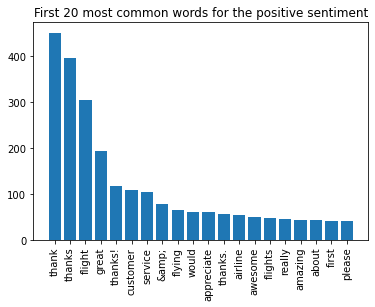

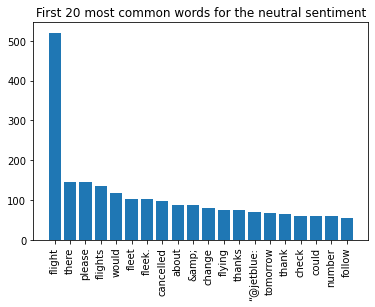

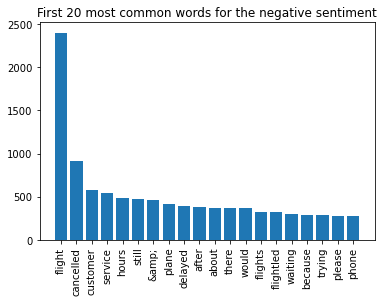

In [9]:
import re # Imported because its split() method is very useful
selected = 20 # Number of the X most frequent words shown
minlen = 4 # Minimum length for a word to be added in the dataset
for sentiment in ['positive', 'neutral', 'negative']: # For each sentiment
    word_dict = {} # Create a dict that will contain pairs (word, number_occurencies)
    for tweet in tweet_df[tweet_df['airline_sentiment']==sentiment]['text']: # For each tweet of the current sentiment
        for word in re.split("'| ", tweet): # Split the words in the tweet for each blankspace and each ' (to get rid of it's, that's etc)
            if len(word) > minlen and word[0] != '@': # If a word is longer than minlen and is not a quote (doesn't start with @)
                word_dict[word.lower()] = word_dict.get(word.lower(), 0) + 1 # Update frequency count
    ordered_dict = dict(sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:selected]) # Sort the dict
    fig, ax = plt.subplots() # Create plot
    ax.bar(ordered_dict.keys(), ordered_dict.values()) # Create histogram
    ax.set_title('First {} most common words for the {} sentiment'.format(selected, sentiment)) # Set title
    plt.xticks(rotation=90) # Rotate xlabel
    plt.show() # Show plot

For what we can see, __flight__ is a good candidate because it's a word that appears in all the three sentiments, but it's more common in the negative sentiment.
Also __thank__ seems to appear mostly in the neutral and positive sentiment, making it a good candidate.
And lastly also __cancelled__ is a good candidate because it seems to appear somewhat frequently in both positive and negative tweets.
Let's store these words in a variable. We will use them later.

In [10]:
interesting_words = ['flight', 'thank', 'cancelled']

### 1.7. The airline_sentiment_confidence column <a class="anchor" id="DP-7"></a>

This column seems to encode the confidence that the sentiment is actually correct: some tweets might be ambiguous therefore one can't be 100% sure of the correctness of a label. We are interested in this column because the presence of one of the words that we found earlier __could__ influence the confidence of a sentiment.
As a first step, let's see what's the minimum, the maximum and how the values are distributed.

Maximum: 1.0
Minimum: 0.335


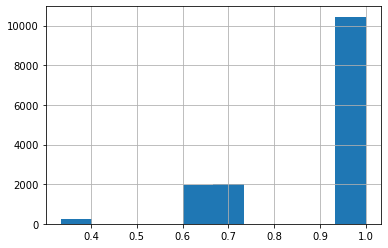

In [11]:
print('Maximum: {}\nMinimum: {}'.format(np.max(tweet_df['airline_sentiment_confidence']), np.min(tweet_df['airline_sentiment_confidence'])))
tweet_df['airline_sentiment_confidence'].hist();

Good! We could apply this mapping:

- Every value __below__ 0.8 is labeled as Low Confidence
- Everything else is High Confidence

Let's do it!

In [12]:
def mapconf(value):
    if value < 0.8:
        return 'Low'
    return 'High'

tweet_df['airline_sentiment_confidence'] = tweet_df['airline_sentiment_confidence'].map(mapconf)
tweet_df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,airline,retweet_count,text,tweet_created,tweet_length
0,neutral,High,None,Virgin America,False,@VirginAmerica What @dhepburn said.,Morning,Short
1,positive,Low,None,Virgin America,False,@VirginAmerica plus you've added commercials t...,Morning,Medium
2,neutral,Low,None,Virgin America,False,@VirginAmerica I didn't today... Must mean I n...,Morning,Medium
3,negative,High,Complaints,Virgin America,False,@VirginAmerica it's really aggressive to blast...,Morning,Long
4,negative,High,None,Virgin America,False,@VirginAmerica and it's a really big bad thing...,Morning,Medium


And that's it! With this last step we concluded the part on data preprocessing. It is now time to dive in the model and in the computation of probabilities.

## 2. Presentation of the model <a class="anchor" id="PM"></a>

### 2.1 The Bayesian Network <a class="anchor" id="PM-1"></a>

![Network](USAirNet.png)

### 2.2. Explanation of the nodes <a class="anchor" id="PM-2"></a>

- __Company:__ Which company the tweet is referred to. 
    - __Domain:__ American, Delta, Southwest, US Airways, United, Virgin America
- __City:__ The city from which the plane starts the trip.
    - __Domain:__ New York, Los Angeles, Chicago
- __Bad Weather:__ If its raining or not during the flight.
    - __Domain:__ True, False
- __Strike:__ If there is an ongoing strike.
    - __Domain:__ True, False
- __Problems:__ Represents the problems that might have happened with the flight.
    - __Domain:__ Complaints, Customer Service, Delays, None
- __Sentiment:__ The sentiment of the tweet.
    - __Domain:__ Positive, Neutral, Negative
- __Retweets:__ If the tweet has been retweeted or not.
    - __Domain:__ True, False
- __Tweet Time:__ Time of the day in which the tweet has been posted.
    - __Domain:__ Morning, Evening, Noon, Night
- __Tweet Length:__ Length of the tweet.
    - __Domain:__ Short, Medium, Long
- __Flight, Thank and Cancelled:__ They signal if the corresponding word is present in the text of the tweet.
    - __Domain:__ True, False
- __Confidence:__ The confidence for the sentiment assigned to the tweet.
    - __Domain:__ Low, High

### 2.3. Justifications for the choices made <a class="anchor" id="PM-3"></a>

Starting from the top of the network, I will give a justification for the choices I've made.

- Starting from the very top, it makes sense to say that a specific company may increase the probability of mishaps. For example, a company may be known for having unconfortable seats, or a very bad customer service.
- The city can influence the probability of bad weather.
- Bad weather condition may influence the probability of delays happening. It shouldn't affect the probability of bad flights or bad customer service.
- Strikes may increase the probability of delays happening, or may worsen the customer service's condition due to the shortage of employees. It shouldn't affect the probability of Problems=Complaints about the flight itself, since this is more related to bad seats, bad mannered staff, bad food, lost luggages...
- Problems make the sentiment negative. But sometimes even the total absence of a particular reason (Problems=None) can still produce a negative sentiment because Problems=None can also mean "can't understand what is the problem expressed in the tweet".
- The sentiment may influence the number of retweets of a particular tweet, in fact people may be more inclined to share with others a really bad experience with a specific company rather than a tweet in which someone says that everything went great.
- The time of the tweet may influence the number of retweets. In fact it is more likely that tweets posted at night and very early in the morning don't gain enough traction.
- The sentiment may also influence the tweet length. In fact an angry person is more likely to spend a lot of words explaining what happened to them.
- The sentiment could influence the probability of the words __cancelled__, __flight__ and __thank__ to appear.
- These words can influence the confidence in the sentiment.

## 3. Computing Probabilities <a class="anchor" id="CP"></a>

### 3.1. Company Probability <a class="anchor" id="CP-1"></a> [[jump to pgmpy implementation]](#PI-3)

Let's compute the probability of each one of the possible companies.

In [13]:
total_rows = tweet_df.shape[0]
total_sum = 0
for comp in np.unique(tweet_df['airline']):
    count = tweet_df[tweet_df['airline']==comp].shape[0]
    total_sum += round(count/total_rows, 2)
    print('P(airline={}) = {}'.format(comp, round(count/total_rows, 2)))
print('Total sum = {}'.format(total_sum))

P(airline=American) = 0.19
P(airline=Delta) = 0.15
P(airline=Southwest) = 0.17
P(airline=US Airways) = 0.2
P(airline=United) = 0.26
P(airline=Virgin America) = 0.03
Total sum = 1.0


That .01 probably is due to rounding errors. The probability table looks like this:

|| American | Delta | Southwest | US Airways | United | Virgin America |
| --- | --- | --- | --- | --- | --- | --- |
| Company | 0.19 | 0.15 | 0.17 | 0.2 | 0.26 | 0.03 |

### 3.2. Strike Probability <a class="anchor" id="CP-2"></a> [[jump to pgmpy implementation]](#PI-4)

I tried to do a bit of research on the probability of a strike to happen, but sadly I didn't find any major results. From the articles found online I can assume is fairly improbable. I think the probabilty table will look like this:

|| True | False |
|---|---|---|
| Strike | 0.99 | 0.01 |

### 3.3. City Probability <a class="anchor" id="CP-3"></a> [[jump to pgmpy implementation]](#PI-5)

This is the probability of a plane to start the flight on a given city. Since this data is very hard to retrieve we'll need to get creative again. For this node I took 3 among the most known US cities:

|| New York | Los Angeles | Chicago |
| --- | --- | --- | --- |
| City | 0.45 | 0.35 | 0.2 |

### 3.4 Probability of Bad Weather given City <a class="anchor" id="CP-4"></a>[[jump to pgmpy implementation]](#PI-6)

Clearly, every city has a different probability of having bad weather. From this source (https://www.currentresults.com/Weather/US/average-annual-precipitation-by-city.php) we can see that:

- __Chicago__ has on average of 127 days of rain in a year.
- __Los Angeles__ has on average 34 days of rain in a year.
- __New York__ has on average 125 days of rain in a year.

This brings us to this probability table (assuming 365 days per year):

|| Bad Weather = True | Bad Weather = False |
| --- | --- | --- |
| Chicago | 0.34 | 0.66 |
| Los Angeles | 0.09 | 0.91 |
| New York | 0.33 | 0.67 |

### 3.5. Probability of Problems given Company, Strike and Bad Weather <a class="anchor" id="CP-5"></a> [[jump to pgmpy implementation]](#PI-7)

We can partially extract this information directly from the dataset. For simplicity we assume that the data in the dataset have __Strike=False__ and __Bad Weather=False__, in this way we can use the extracted probabilities as a lower bound for the cases in which Strike or Bad Weather are not False. 

In [14]:
airlines = np.unique(tweet_df['airline'])
for airline in airlines:
    for p in np.unique(tweet_df['negativereason']):
        f_df = tweet_df[tweet_df['airline']==airline] # Extract all rows with a given company
        p_df = f_df[f_df['negativereason']==p] # Extract all rows with a given company AND the specified negativereason
        print('P(Problems={}|Company={}, Strike=False, Bad Weather=False)={}'.format(p, airline, round(p_df.shape[0]/f_df.shape[0], 2)))

P(Problems=Complaints|Company=American, Strike=False, Bad Weather=False)=0.12
P(Problems=Customer Service|Company=American, Strike=False, Bad Weather=False)=0.41
P(Problems=Delay|Company=American, Strike=False, Bad Weather=False)=0.1
P(Problems=None|Company=American, Strike=False, Bad Weather=False)=0.36
P(Problems=Complaints|Company=Delta, Strike=False, Bad Weather=False)=0.09
P(Problems=Customer Service|Company=Delta, Strike=False, Bad Weather=False)=0.13
P(Problems=Delay|Company=Delta, Strike=False, Bad Weather=False)=0.13
P(Problems=None|Company=Delta, Strike=False, Bad Weather=False)=0.65
P(Problems=Complaints|Company=Southwest, Strike=False, Bad Weather=False)=0.1
P(Problems=Customer Service|Company=Southwest, Strike=False, Bad Weather=False)=0.25
P(Problems=Delay|Company=Southwest, Strike=False, Bad Weather=False)=0.07
P(Problems=None|Company=Southwest, Strike=False, Bad Weather=False)=0.58
P(Problems=Complaints|Company=US Airways, Strike=False, Bad Weather=False)=0.13
P(Problem

So the CPT is:

| Company | Strike | Bad Weather | Complaints | Customer Service | Delay | None |
| --- | --- | --- | --- | --- | --- | --- |
| American | False | False | 0.12 | 0.41 | 0.11 | 0.36 |
| American | True | False | 0.12 | 0.5 | 0.3 | 0.08 |
| American | False | True | 0.12 | 0.41 | 0.4 | 0.07 |
| American | True | True | 0.12 | 0.4 | 0.48 | 0 |
| Delta | False | False | 0.09 | 0.13 | 0.13 | 0.65 |
| Delta | True | False | 0.09 | 0.25 | 0.2 | 0.46 |
| Delta | False | True | 0.09 | 0.13 | 0.3 | 0.48 |
| Delta | True | True | 0.09 | 0.35 | 0.4 | 0.16 |
| Southwest | False | False | 0.1 | 0.25 | 0.07 | 0.58 |
| Southwest | True | False | 0.1 | 0.35 | 0.15 | 0.4 |
| Southwest | False | True | 0.1 | 0.25 | 0.3 | 0.35 |
| Southwest | True | True | 0.1 | 0.4 | 0.35 | 0.15 |
| US Airways | False | False | 0.13 | 0.39 | 0.17 | 0.31 |
| US Airways | True | False | 0.13 | 0.5 | 0.2 | 0.17 |
| US Airways | False | True | 0.13 | 0.39 | 0.3 | 0.18 |
| US Airways | True | True | 0.13 | 0.5 | 0.33 | 0.04 |
| United | False | False | 0.18 | 0.26 | 0.15 | 0.41 |
| United | True | False | 0.18 | 0.37 | 0.22 | 0.23 |
| United | False | True | 0.18 | 0.26 | 0.3 | 0.26 |
| United | True | True | 0.18 | 0.4 | 0.37 | 0.05 |
| Virgin America | False | False | 0.07 | 0.21 | 0.04 | 0.78 |
| Virgin America | True | False | 0.07 | 0.32 | 0.1 | 0.51 |
| Virgin America | False | True | 0.07 | 0.21 | 0.22 | 0.5 |
| Virgin America | True | True | 0.07 | 0.4 | 0.3 | 0.23 |

As a reminder, the fields where Strike or Bad Weather are True are invented, and as a lower bound I used the probabilities when they are both False (computed from the dataset).

### 3.6. Probability of Sentiment given Problems <a class="anchor" id="CP-6"></a> [[jump to pgmpy implementation]](#PI-8)

Computable directly from the dataset. Let's dive into it:

In [15]:
sentiments = np.unique(tweet_df['airline_sentiment'])
negreason = list(np.unique(tweet_df['negativereason']))
for sentiment in sentiments:
    for reason in negreason:
        n_df = tweet_df[tweet_df['negativereason']==reason] # All rows with given problem
        s_df = n_df[n_df['airline_sentiment']==sentiment] # All rows with given problem AND given sentiment
        print('P(Sentiment={}|{}=True)={}'.format(sentiment, reason, round(s_df.shape[0]/n_df.shape[0] ,2)))

P(Sentiment=negative|Complaints=True)=1.0
P(Sentiment=negative|Customer Service=True)=1.0
P(Sentiment=negative|Delay=True)=1.0
P(Sentiment=negative|None=True)=0.18
P(Sentiment=neutral|Complaints=True)=0.0
P(Sentiment=neutral|Customer Service=True)=0.0
P(Sentiment=neutral|Delay=True)=0.0
P(Sentiment=neutral|None=True)=0.47
P(Sentiment=positive|Complaints=True)=0.0
P(Sentiment=positive|Customer Service=True)=0.0
P(Sentiment=positive|Delay=True)=0.0
P(Sentiment=positive|None=True)=0.36


As we can see, every time a negative reason is not None, the sentiment is 100% negative.
On the other hand even if there is no evident reason, a tweet can still be labelled as negative. 
This brings us to the following CPT:

| Problems | Sentiment = Negative | Sentiment = Neutral | Sentiment = Positive |
| --- | --- | --- | --- |
| Complaints | 1 | 0 | 0 |
| Customer Service | 1 | 0 | 0 |
| Delays | 1 | 0 | 0 |
| None | 0.18 | 0.47 | 0.36 |

### 3.7. Probability of Tweet Time <a class="anchor" id="CP-7"></a>[[jump to pgmpy implementation]](#PI-9)

Let's extract from the dataset the probability of Tweet Time:

In [16]:
time = np.unique(tweet_df['tweet_created'])
for t in time:
    ti_df = tweet_df[tweet_df['tweet_created']==t]
    print('P({})={}'.format(t, round(ti_df.shape[0]/tweet_df.shape[0] ,2)))

P(Evening)=0.2
P(Morning)=0.36
P(Night)=0.1
P(Noon)=0.34


The probability table will be:

|| Morning | Evening | Night | Noon |
| --- | --- | --- | --- | --- |
|| 0.36 | 0.2 | 0.34 | 0.1 |

### 3.8. Probabilty of Retweet given Time and Sentiment <a class="anchor" id="CP-8"></a> [[jump to pgmpy implementation]](#PI-10)

This information can be computed directly from the dataset, so let's compute it:

In [17]:
sentiments = np.unique(tweet_df['airline_sentiment'])
time = np.unique(tweet_df['tweet_created'])
for s in sentiments:
    for t in time:
        f_df = tweet_df[(tweet_df['tweet_created']==t) & (tweet_df['airline_sentiment']==s)] # Rows with given sentiment AND given time
        r_df = f_df[f_df['retweet_count']=='True'] # From these extract the ones with retweets
        print('P(Retweet=True|Sentiment={}, Time={})={}'.format(s, t, round(r_df.shape[0]/f_df.shape[0], 2)))

P(Retweet=True|Sentiment=negative, Time=Evening)=0.08
P(Retweet=True|Sentiment=negative, Time=Morning)=0.05
P(Retweet=True|Sentiment=negative, Time=Night)=0.04
P(Retweet=True|Sentiment=negative, Time=Noon)=0.07
P(Retweet=True|Sentiment=neutral, Time=Evening)=0.03
P(Retweet=True|Sentiment=neutral, Time=Morning)=0.03
P(Retweet=True|Sentiment=neutral, Time=Night)=0.02
P(Retweet=True|Sentiment=neutral, Time=Noon)=0.04
P(Retweet=True|Sentiment=positive, Time=Evening)=0.03
P(Retweet=True|Sentiment=positive, Time=Morning)=0.03
P(Retweet=True|Sentiment=positive, Time=Night)=0.02
P(Retweet=True|Sentiment=positive, Time=Noon)=0.04


It seems that, even if it's fairly unlikely that a tweet has retweets, it's a bit more likely that negative tweets get retweeted more often than positive or neutral tweets. Furthermore it's seems that tweets that get retweeted are posted during the evening or during the morning.

This confirms the hypothesis that people tend to retweet negative tweets, even if the increase in the probability is minimal.

The CPT is:

| Sentiment | Time | Retweet |
| --- | --- | --- |
| Negative | Evening | 0.08 |
| Negative | Morning | 0.05 |
| Negative | Night | 0.04 |
| Negative | Noon | 0.07 |
| Neutral | Evening | 0.03 |
| Neutral | Morning | 0.03 |
| Neutral | Night | 0.02 |
| Neutral| Noon | 0.04 |
| Positive | Evening | 0.03 |
| Positive | Morning | 0.03 |
| Positive | Night | 0.02 |
| Positive | Noon | 0.04 |

### 3.9. Probability of Length given Sentiment <a class="anchor" id="CP-9"></a> [[jump to pgmpy implementation]](#PI-11)

Let's compute it directly from the dataset:

In [18]:
length = np.unique(tweet_df['tweet_length'])
for l in length:
    for s in sentiments:
        f_df = tweet_df[tweet_df['airline_sentiment']==s] # Rows with given Sentiment
        l_df = f_df[f_df['tweet_length']==l] # From these extract the ones with a given Tweet Length
        print('P(Length={}|Sentiment={})={}'.format(l, s, round(l_df.shape[0]/f_df.shape[0], 2)))

P(Length=Long|Sentiment=negative)=0.64
P(Length=Long|Sentiment=neutral)=0.33
P(Length=Long|Sentiment=positive)=0.34
P(Length=Medium|Sentiment=negative)=0.29
P(Length=Medium|Sentiment=neutral)=0.44
P(Length=Medium|Sentiment=positive)=0.4
P(Length=Short|Sentiment=negative)=0.06
P(Length=Short|Sentiment=neutral)=0.23
P(Length=Short|Sentiment=positive)=0.26


Thus we obtain the following CPT:

| Sentiment | Length = Long | Length = Medium | Length = Short |
| --- | --- | --- | --- |
| Negative | 0.64 | 0.29 | 0.06 |
| Neutral | 0.33 | 0.44 | 0.23 |
| Positive | 0.34 | 0.4 | 0.26 |

It seems that a long tweet is likely to be a negative one, while a short one is likely to be neutral or positive.

### 3.10. Probability of Flight, Thank and Cancelled given the Sentiment <a class="anchor" id="CP-10"></a> [[jump to pgmpy implementation]](#PI-12)

Also this information can be retrieved directly from the dataset:

In [19]:
for word in interesting_words:
    for s in sentiments:
        f_df = tweet_df[tweet_df['airline_sentiment']==s]
        w_df = f_df[f_df['text'].str.contains(word, case=False)]
        print('P({}|{})={}'.format(word, s, round(w_df.shape[0]/f_df.shape[0] ,2)))

P(flight|negative)=0.34
P(flight|neutral)=0.24
P(flight|positive)=0.18
P(thank|negative)=0.04
P(thank|neutral)=0.07
P(thank|positive)=0.45
P(cancelled|negative)=0.1
P(cancelled|neutral)=0.03
P(cancelled|positive)=0.02


So the CPTs are:

| Sentiment | Flight |
| --- | --- |
| Negative | 0.34 |
| Neutral | 0.24 |
| Positive | 0.18 |

| Sentiment | Thank |
| --- | --- |
| Negative | 0.04 |
| Neutral | 0.07 |
| Positive | 0.45 |

| Sentiment | Cancelled |
| --- | --- |
| Negative | 0.1 |
| Neutral | 0.03 |
| Positive | 0.02 |

### 3.11. Probability of Confidence given Flight, Cancelled and Thank <a class="anchor" id="CP-11"></a> [[jump to pgmpy implementation]](#PI-13)

This is a probability computable directly from the dataset, let's do it!

In [20]:
# Each element of assign list is a triple of the form (bool, bool, bool).
# If the bool at index I is True, that means that interesting_words[I] must be present in the text
# So assign_list is a list of masks! The first element filters for all the texts in which none of the target words are present
# And so on...

assign_list = [(False, False, False),
               (True, False, False),
               (False, True, False),
               (False, False, True),
               (True, True, False),
               (False, True, True),
               (True, False, True),
               (True, True, True)]
for fil in assign_list:
    # Apply filter fil
    f_df = f_df = tweet_df[(tweet_df['text'].str.contains(interesting_words[0], case=False)==fil[0]) & 
                 (tweet_df['text'].str.contains(interesting_words[1], case=False)==fil[1]) & 
                 (tweet_df['text'].str.contains(interesting_words[2], case=False)==fil[2])]
    # Check the number of high confidence
    c_df = f_df[f_df['airline_sentiment_confidence']=='High']
    # Compute probability only if f_df has elements in it, otherwise return 0
    if f_df.shape[0] != 0:
        prob = round(c_df.shape[0]/f_df.shape[0] ,2)
    else:
        prob = 0
    print('P(High|{}={}, {}={}, {}={})={}'.format(interesting_words[0], fil[0],
                                                  interesting_words[1], fil[1],
                                                  interesting_words[2], fil[2],
                                                  prob))

P(High|flight=False, thank=False, cancelled=False)=0.7
P(High|flight=True, thank=False, cancelled=False)=0.75
P(High|flight=False, thank=True, cancelled=False)=0.65
P(High|flight=False, thank=False, cancelled=True)=0
P(High|flight=True, thank=True, cancelled=False)=0.71
P(High|flight=False, thank=True, cancelled=True)=0
P(High|flight=True, thank=False, cancelled=True)=0.82
P(High|flight=True, thank=True, cancelled=True)=0.69


So our CPT is:

| Flight | Thank | Cancelled | Confidence=High |
| --- | --- | --- | --- |
| False | False | False | 0.7 |
| True | False | False | 0.75 |
| False | True | False | 0.65 |
| False | False | True | 0 |
| True | True | False | 0.71 |
| False | True | True | 0 |
| True | False | True | 0.82 |
| True | True | True | 0.69 |

## 4. Pgmpy Implementation  <a class="anchor" id="PI"></a>

### 4.1. Installation and imports  <a class="anchor" id="PI-1"></a>

First thing first, we need to install pgmpy and import the features that we'll need:

In [21]:
!pip install pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

### 4.2. Implementing the network's structure <a class="anchor" id="PI-2"></a>

First step, let's define the structure of the model.

In [22]:
airline_model = BayesianNetwork([('City', 'Bad Weather'), 
                                 ('Bad Weather', 'Problems'),
                                 ('Company', 'Problems'),
                                 ('Strike', 'Problems'),
                                 ('Problems', 'Sentiment'),
                                 ('Sentiment', 'Retweets'),
                                 ('Tweet Time', 'Retweets'),
                                 ('Sentiment', 'Tweet Length'),
                                 ('Sentiment', 'Flight'),
                                 ('Sentiment', 'Thank'),
                                 ('Sentiment', 'Cancelled'),
                                 ('Flight', 'Confidence'),
                                 ('Thank', 'Confidence'),
                                 ('Cancelled', 'Confidence')])

### 4.3. The Company Table <a class="anchor" id="PI-3"></a> [[jump to table]](#CP-1)

In [23]:
company_cpd=TabularCPD('Company', 6, [[.19], [.15], [.17], [.2], [.26], [.03]])
print(company_cpd)

+------------+------+
| Company(0) | 0.19 |
+------------+------+
| Company(1) | 0.15 |
+------------+------+
| Company(2) | 0.17 |
+------------+------+
| Company(3) | 0.2  |
+------------+------+
| Company(4) | 0.26 |
+------------+------+
| Company(5) | 0.03 |
+------------+------+


### 4.4. The Strike Table <a class="anchor" id="PI-4"></a> [[jump to table]](#CP-2)

In [24]:
strike_cpd=TabularCPD('Strike', 2, [[.99], [.01]])
print(strike_cpd)

+-----------+------+
| Strike(0) | 0.99 |
+-----------+------+
| Strike(1) | 0.01 |
+-----------+------+


### 4.5. The City Table <a class="anchor" id="PI-5"></a> [[jump to table]](#CP-3)

In [25]:
city_cpd=TabularCPD('City', 3, [[.45], [.35], [.2]])
print(city_cpd)

+---------+------+
| City(0) | 0.45 |
+---------+------+
| City(1) | 0.35 |
+---------+------+
| City(2) | 0.2  |
+---------+------+


### 4.6. The Bad Weather Table <a class="anchor" id="PI-6"></a> [[jump to table]](#CP-4)

In [26]:
bad_weather_cpd=TabularCPD('Bad Weather',
                           2,
                           [[.67, .91, .66],
                            [.33, .09, .34]],
                           evidence=['City'],
                           evidence_card=[3])
print(bad_weather_cpd)

+----------------+---------+---------+---------+
| City           | City(0) | City(1) | City(2) |
+----------------+---------+---------+---------+
| Bad Weather(0) | 0.67    | 0.91    | 0.66    |
+----------------+---------+---------+---------+
| Bad Weather(1) | 0.33    | 0.09    | 0.34    |
+----------------+---------+---------+---------+


### 4.7. The Problems Table <a class="anchor" id="PI-7"></a> [[jump to table]](#CP-5)

In [27]:
problems_cpd=TabularCPD('Problems',
                         4,
                         [[.12, .12, .12, .12, .09, .09, .09, .09, .1, .1, .1, .1, .13, .13, .13, .13, .18, .18, .18, .18, .07, .07, .07, .07], 
                          [.40, .5, .41, .4, .13, .25, .13, .35, .25, .35, .25, .4, .39, .5, .39, .5, .26, .37, .26, .4, .21, .32, .21, .4], 
                          [.12, .3, .4, .48, .13, .2, .3, .4, .07, .15, .3, .35, .17,.2, .3, .33, .15, .22, .3, .37, .04, .1, .22, .3], 
                          [.36, .08, .07, 0, .65, .46, .48, .16, .58, .4, .35, .15, .31, .17, .18, .04, .41, .23, .26, .05, .68, .51, .5, .23]],
                           evidence=['Company', 'Bad Weather', 'Strike'],
                           evidence_card=[6, 2, 2])
print(problems_cpd)

+-------------+----------------+----------------+-----+----------------+----------------+----------------+
| Company     | Company(0)     | Company(0)     | ... | Company(5)     | Company(5)     | Company(5)     |
+-------------+----------------+----------------+-----+----------------+----------------+----------------+
| Bad Weather | Bad Weather(0) | Bad Weather(0) | ... | Bad Weather(0) | Bad Weather(1) | Bad Weather(1) |
+-------------+----------------+----------------+-----+----------------+----------------+----------------+
| Strike      | Strike(0)      | Strike(1)      | ... | Strike(1)      | Strike(0)      | Strike(1)      |
+-------------+----------------+----------------+-----+----------------+----------------+----------------+
| Problems(0) | 0.12           | 0.12           | ... | 0.07           | 0.07           | 0.07           |
+-------------+----------------+----------------+-----+----------------+----------------+----------------+
| Problems(1) | 0.4            | 0.5 

### 4.8. The Sentiment Table <a class="anchor" id="PI-8"></a> [[jump to table]](#CP-6)

In [28]:
sentiment_cpd=TabularCPD('Sentiment',
                           3,
                           [[1, 1, 1, .18], [0, 0, 0, .47], [0, 0, 0, .36]],
                           evidence=['Problems'],
                           evidence_card=[4])
print(sentiment_cpd)

+--------------+-------------+-------------+-------------+-------------+
| Problems     | Problems(0) | Problems(1) | Problems(2) | Problems(3) |
+--------------+-------------+-------------+-------------+-------------+
| Sentiment(0) | 1.0         | 1.0         | 1.0         | 0.18        |
+--------------+-------------+-------------+-------------+-------------+
| Sentiment(1) | 0.0         | 0.0         | 0.0         | 0.47        |
+--------------+-------------+-------------+-------------+-------------+
| Sentiment(2) | 0.0         | 0.0         | 0.0         | 0.36        |
+--------------+-------------+-------------+-------------+-------------+


### 4.9. The Tweet Time Table <a class="anchor" id="PI-9"></a> [[jump to table]](#CP-7)

In [29]:
ttime_cpd=TabularCPD('Tweet Time', 4, [[.36], [.1], [.2], [.34]])
print(ttime_cpd)

+---------------+------+
| Tweet Time(0) | 0.36 |
+---------------+------+
| Tweet Time(1) | 0.1  |
+---------------+------+
| Tweet Time(2) | 0.2  |
+---------------+------+
| Tweet Time(3) | 0.34 |
+---------------+------+


### 4.10. The Retweet Table <a class="anchor" id="PI-10"></a> [[jump to table]](#CP-8)

In [30]:
retweet_cpd=TabularCPD('Retweets', 
                       2, 
                       [[.95, .93, .92, .96, .97, .96, .97, .98, .97, .96, .97, .98],
                        [.05, .07, .08, .04, .03, .04, .03, .02, .03, .04, .03, .02]],
                       evidence=['Sentiment', 'Tweet Time'],
                       evidence_card=[3, 4])
print(retweet_cpd)

+-------------+---------------+---------------+-----+---------------+---------------+---------------+
| Sentiment   | Sentiment(0)  | Sentiment(0)  | ... | Sentiment(2)  | Sentiment(2)  | Sentiment(2)  |
+-------------+---------------+---------------+-----+---------------+---------------+---------------+
| Tweet Time  | Tweet Time(0) | Tweet Time(1) | ... | Tweet Time(1) | Tweet Time(2) | Tweet Time(3) |
+-------------+---------------+---------------+-----+---------------+---------------+---------------+
| Retweets(0) | 0.95          | 0.93          | ... | 0.96          | 0.97          | 0.98          |
+-------------+---------------+---------------+-----+---------------+---------------+---------------+
| Retweets(1) | 0.05          | 0.07          | ... | 0.04          | 0.03          | 0.02          |
+-------------+---------------+---------------+-----+---------------+---------------+---------------+


### 4.11. The Length Table <a class="anchor" id="PI-11"></a> [[jump to table]](#CP-9)

In [31]:
length_cpd=TabularCPD('Tweet Length', 
                       3, 
                       [[.64, .33, .34], 
                        [.29, .44, .4],
                        [.06, .23, .26]],
                       evidence=['Sentiment'],
                       evidence_card=[3])
print(length_cpd)

+-----------------+--------------+--------------+--------------+
| Sentiment       | Sentiment(0) | Sentiment(1) | Sentiment(2) |
+-----------------+--------------+--------------+--------------+
| Tweet Length(0) | 0.64         | 0.33         | 0.34         |
+-----------------+--------------+--------------+--------------+
| Tweet Length(1) | 0.29         | 0.44         | 0.4          |
+-----------------+--------------+--------------+--------------+
| Tweet Length(2) | 0.06         | 0.23         | 0.26         |
+-----------------+--------------+--------------+--------------+


### 4.12. The Flight, Thank and Cancelled Tables <a class="anchor" id="PI-12"></a> [[jump to table]](#CP-10)

In [32]:
flight_cpd=TabularCPD('Flight', 
                       2, 
                       [[.66, .76, .82],
                        [.34, .24, .18]],
                       evidence=['Sentiment'],
                       evidence_card=[3])
thank_cpd=TabularCPD('Thank', 
                      2, 
                      [[.96, .93, .55],
                       [.04, .07, .45]],
                      evidence=['Sentiment'],
                      evidence_card=[3])
cancelled_cpd=TabularCPD('Cancelled', 
                         2, 
                         [[.9, .97, .98],
                          [.1, .03, .02]],
                         evidence=['Sentiment'],
                         evidence_card=[3])
print(flight_cpd)
print(thank_cpd)
print(cancelled_cpd)

+-----------+--------------+--------------+--------------+
| Sentiment | Sentiment(0) | Sentiment(1) | Sentiment(2) |
+-----------+--------------+--------------+--------------+
| Flight(0) | 0.66         | 0.76         | 0.82         |
+-----------+--------------+--------------+--------------+
| Flight(1) | 0.34         | 0.24         | 0.18         |
+-----------+--------------+--------------+--------------+
+-----------+--------------+--------------+--------------+
| Sentiment | Sentiment(0) | Sentiment(1) | Sentiment(2) |
+-----------+--------------+--------------+--------------+
| Thank(0)  | 0.96         | 0.93         | 0.55         |
+-----------+--------------+--------------+--------------+
| Thank(1)  | 0.04         | 0.07         | 0.45         |
+-----------+--------------+--------------+--------------+
+--------------+--------------+--------------+--------------+
| Sentiment    | Sentiment(0) | Sentiment(1) | Sentiment(2) |
+--------------+--------------+--------------+----

### 4.13. The Confidence Table <a class="anchor" id="PI-13"></a> [[jump to table]](#CP-11)

In [33]:
confidence_cpd=TabularCPD('Confidence',
                          2, 
                          [[.7, 0, .65, 0, .75, .82, .71, .69], 
                           [.3, 1, .35, 1, .25, .18, .29, .31]],
                          evidence=['Flight', 'Thank', 'Cancelled'],
                          evidence_card=[2, 2, 2])
print(confidence_cpd)

+---------------+--------------+--------------+-----+--------------+--------------+--------------+
| Flight        | Flight(0)    | Flight(0)    | ... | Flight(1)    | Flight(1)    | Flight(1)    |
+---------------+--------------+--------------+-----+--------------+--------------+--------------+
| Thank         | Thank(0)     | Thank(0)     | ... | Thank(0)     | Thank(1)     | Thank(1)     |
+---------------+--------------+--------------+-----+--------------+--------------+--------------+
| Cancelled     | Cancelled(0) | Cancelled(1) | ... | Cancelled(1) | Cancelled(0) | Cancelled(1) |
+---------------+--------------+--------------+-----+--------------+--------------+--------------+
| Confidence(0) | 0.7          | 0.0          | ... | 0.82         | 0.71         | 0.69         |
+---------------+--------------+--------------+-----+--------------+--------------+--------------+
| Confidence(1) | 0.3          | 1.0          | ... | 0.18         | 0.29         | 0.31         |
+---------

### 4.14. Building the model <a class="anchor" id="PI-14"></a>

First thing first, let's add all the tables to the model.

In [34]:
airline_model.add_cpds(company_cpd,
                       strike_cpd,
                       city_cpd,
                       bad_weather_cpd,
                       problems_cpd,
                       sentiment_cpd,
                       ttime_cpd,
                       retweet_cpd,
                       length_cpd,
                       flight_cpd,
                       thank_cpd,
                       cancelled_cpd,
                       confidence_cpd)

Let's check that everything is fine:

In [35]:
if airline_model.check_model():
    print('No errors found within the model.')

No errors found within the model.


And that's it! Now we can start to perform some queries.

## 5. Queries <a class="anchor" id="Q"></a>

In this section we perform queries on the network to experiment with the data we have extracted and we'll also test the sampling feature of pgmpy.

### 5.1. The "pgmpy translation" <a class="anchor" id="Q-1"></a>

Pgmpy maps the domain of a variable into numbers going from 0 to the cardinality of said variable. Since for example the probability of company being Southwest given a positive sentiment is written as P(Company=2|Sentiment=2) could be confusing, I will build a dictionary of dictionaries with this structure:

- The first dictionary will contain pairs (Variable: dict) for each variable
- The dictionaries inside the pairs will contain pairs of the form (Variable Value: Pgmpy Value). An example could be ('Virgin America: 4)

In this way P(Company=2|Sentiment=2) will be written like: P(Company=d\['Company'\]\['Southwest'\] | Sentiment=d\['Sentiment'\]\['Positive'\])

In [36]:
t_d = {
    'Company': {
        'American': 0,
        'Delta': 1,
        'Southwest': 2,
        'US Airways': 3,
        'United': 4,
        'Virgin America': 5
    },
    'Strike': {
        'False': 0,
        'True': 1
    },
    'City': {
        'New York': 0,
        'Los Angeles': 1,
        'Chicago': 2
    },
    'Bad Weather': {
        'False': 0,
        'True': 1
    },
    'Problems': {
        'Complaints': 0,
        'Customer Service': 1,
        'Delays': 2,
        'None': 3
    },
    'Sentiment': {
        'Negative': 0,
        'Neutral': 1,
        'Positive': 2
    },
    'Tweet Time': {
        'Morning': 0,
        'Noon': 1,
        'Evening': 2,
        'Night': 3
    },
    'Retweets': {
        'False': 0,
        'True': 1
    },
    'Tweet Length': {
        'Long': 0,
        'Medium': 1,
        'Short': 2
    },
    'Flight': {
        'False': 0,
        'True': 1
    },
    'Thank': {
        'False': 0,
        'True': 1
    },
    'Cancelled': {
        'False': 0,
        'True': 1
    },
    'Confidence': {
        'High': 0,
        'Low': 1
    }
}

Perfect. We can now start computing some queries.

### 5.2. Queries <a class="anchor" id="Q-2"></a>

First, let's create the inference object that we'll use for the queries:

In [37]:
airline_inf = VariableElimination(airline_model)

#### 5.2.1. Query 1 <a class="anchor" id="Q-2-1"></a>

Let's say that we know that a tweet has the word 'Flight' in it, what's the probability that the user didn't experience any problems?

In [38]:
evidence = {'Flight': t_d['Flight']['True']}
q1 = airline_inf.query(['Problems'], evidence)
print(q1)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1457 |
+-------------+-----------------+
| Problems(1) |          0.3314 |
+-------------+-----------------+
| Problems(2) |          0.1999 |
+-------------+-----------------+
| Problems(3) |          0.3229 |
+-------------+-----------------+


It's likely that the user had some problems!
Let's now say that the word 'Cancelled' is in the tweet. This should lower the probability of Problems=3 (None).

In [39]:
evidence['Cancelled'] = t_d['Cancelled']['True']
q2 = airline_inf.query(['Problems'], evidence)
print(q2)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1771 |
+-------------+-----------------+
| Problems(1) |          0.4026 |
+-------------+-----------------+
| Problems(2) |          0.2429 |
+-------------+-----------------+
| Problems(3) |          0.1774 |
+-------------+-----------------+


Yes! As expected the probability of Problems=None is lowered, it went from 0.32 to 0.17.
Now let's say that we also know that the word 'Thank' is not in tweet. This should lower the probability even more:

In [40]:
evidence['Thank'] = t_d['Thank']['False']
q3 = airline_inf.query(['Problems'], evidence)
print(q3)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1790 |
+-------------+-----------------+
| Problems(1) |          0.4070 |
+-------------+-----------------+
| Problems(2) |          0.2456 |
+-------------+-----------------+
| Problems(3) |          0.1684 |
+-------------+-----------------+


The probability is lower, but not by a significant amount.
Now what if the tweet is a short one? From [what we've seen](#CP-9) short tweets are more likely to be neutral or positive!

In [41]:
evidence['Tweet Length'] = t_d['Tweet Length']['Short']
q4 = airline_inf.query(['Problems'], evidence)
print(q4)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1497 |
+-------------+-----------------+
| Problems(1) |          0.3405 |
+-------------+-----------------+
| Problems(2) |          0.2054 |
+-------------+-----------------+
| Problems(3) |          0.3044 |
+-------------+-----------------+


Wow, the probability of Problems=None jumped again to 0.3!

Now, does knowing the time at which the tweet was posted affect in any way the probability of Problems? In theory it shouldn't since the node Retweets is not in the evidence and thus there shouldn't be no active trails between Tweet time and Problems.

Let's define a function to check if there are active trails between two nodes given the evidence and then let's apply it

In [42]:
def is_active(query, evidence, unknown):
    active = airline_model.active_trail_nodes([query], observed=list(evidence.keys())) # Lists of all active nodes
    if unknown in active[query]:
        print('There is an active trail between {} and {}'.format(query, unknown))
    else:
        print('There are no active trails between {} and {}'.format(query, unknown))

In [43]:
is_active('Problems', evidence, 'Tweet Time')

There are no active trails between Problems and Tweet Time


Very good! Let's still compute the probability to check if everythingbehaves as expected:

In [44]:
evidence['Tweet Time'] = t_d['Tweet Time']['Morning']
q5 = airline_inf.query(['Problems'], evidence)
print(q5)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1497 |
+-------------+-----------------+
| Problems(1) |          0.3405 |
+-------------+-----------------+
| Problems(2) |          0.2054 |
+-------------+-----------------+
| Problems(3) |          0.3044 |
+-------------+-----------------+


As expected, the cpds between the fourth and fifth query are identical.

Let's remove Tweet Time from the evidence and let's see how Retweets=True influences Problems.

In [45]:
evidence.pop('Tweet Time')
evidence['Retweets'] = t_d['Retweets']['True']
q6 = airline_inf.query(['Problems'], evidence)
print(q6)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1680 |
+-------------+-----------------+
| Problems(1) |          0.3819 |
+-------------+-----------------+
| Problems(2) |          0.2304 |
+-------------+-----------------+
| Problems(3) |          0.2197 |
+-------------+-----------------+


Apparently having retweets increases the probability of problems. What if there are no retweets?

In [46]:
evidence['Retweets'] = t_d['Retweets']['False']
q7 = airline_inf.query(['Problems'], evidence)
print(q7)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+-------------+-----------------+
| Problems    |   phi(Problems) |
+=============+=================+
| Problems(0) |          0.1488 |
+-------------+-----------------+
| Problems(1) |          0.3384 |
+-------------+-----------------+
| Problems(2) |          0.2041 |
+-------------+-----------------+
| Problems(3) |          0.3087 |
+-------------+-----------------+


Apparently knowing that there aren't retweets doesn't add meaningful informations.

Anyway, let's set again Retweets=True and let's observe the influence that Tweet Time has on Problems. To better visualize it let's develop a small function that plots the probabilities of the values of a variable while varying the evidence.

In [79]:
def plot_probs(target, var, ev):
    var_val = list(t_d[var].keys()) # All values of the variable we want to modify
    tar_probs = {value: [] for value in list(t_d[target].keys())} # For each value of the variable we are examining, let's save the probabilities
    for value in var_val: # For each value in the variable
        ev[var] = t_d[var][value] # Add to the evidence
        query = airline_inf.query([target], ev, show_progress=False) # Compute query
        for t_val in list(tar_probs.keys()): # For each value of target variable
            tar_probs[t_val].append(query.get_value(**{target: t_d[target][t_val]})) # Store the probability
    for t_val in list(tar_probs.keys()): # Plot
        plt.plot(var_val, tar_probs[t_val], '-o',label=t_val)
    ev.pop(var) # Remove from the evidence the value we used in the function
    plt.legend()
    plt.show()

Perfect, now let's set Retweets=True and let's run the function:

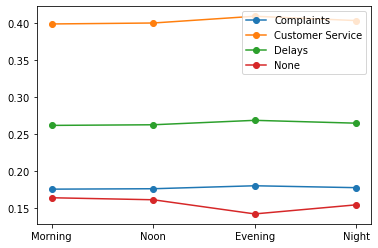

In [81]:
evidence['Retweets'] = t_d['Retweets']['True'] # Add retweets to activate the trail between Tweet Time and Problems
plot_probs('Problems', 'Tweet Time', evidence)

It's seems that the time of the tweet mostly affects the probability of None while the other values remain mostly unchanged.

#### 5.2.2. Query 2 <a class="anchor" id="Q-2-2"></a>

Now let's say that we are interested in predicting the Sentiment. We know that Flight is in the tweet, but Thank and Cancelled aren't. 

In [82]:
evidence = {
    'Flight': t_d['Flight']['True'],
    'Thank': t_d['Thank']['False'],
    'Cancelled': t_d['Cancelled']['False']
}
q8 = airline_inf.query(['Sentiment'], evidence)
print(q8)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.7803 |
+--------------+------------------+
| Sentiment(1) |           0.1636 |
+--------------+------------------+
| Sentiment(2) |           0.0561 |
+--------------+------------------+


Let's say that we know that there were no __evident__ problems expressed in the tweet

In [83]:
evidence['Problems'] = t_d['Problems']['None']
q9 = airline_inf.query(['Sentiment'], evidence)
print(q9)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.2789 |
+--------------+------------------+
| Sentiment(1) |           0.5368 |
+--------------+------------------+
| Sentiment(2) |           0.1843 |
+--------------+------------------+


As expected the probability of a negative sentiment is lower.

If we observe that the tweet is a long one, the probability of a negative sentiment should increase again:

In [84]:
evidence['Tweet Length'] = t_d['Tweet Length']['Long']
q10 = airline_inf.query(['Sentiment'], evidence)
print(q10)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.4268 |
+--------------+------------------+
| Sentiment(1) |           0.4235 |
+--------------+------------------+
| Sentiment(2) |           0.1498 |
+--------------+------------------+


As expected.

Now what happens if we say that the tweet has retweets? In theory the probability of a negative sentiment should increase.

In [85]:
evidence['Retweets'] = t_d['Retweets']['True']
q11 = airline_inf.query(['Sentiment'], evidence)
print(q11)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.5956 |
+--------------+------------------+
| Sentiment(1) |           0.2987 |
+--------------+------------------+
| Sentiment(2) |           0.1057 |
+--------------+------------------+


Exactly! <a class="anchor" id="evening"></a>

Now let's use the function plot_probs to see what are the effects of Tweet Time on Sentiment

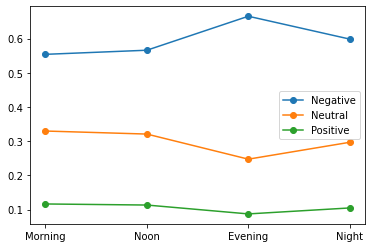

In [86]:
plot_probs('Sentiment', 'Tweet Time', evidence)

Apparently Tweet Time = Evening maximizes the chances of a negative sentiment, meanwhile Morning minimizes them.

In [87]:
evidence['Tweet Time'] = t_d['Tweet Time']['Evening']
q12 = airline_inf.query(['Sentiment'], evidence)
print(q12)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.6650 |
+--------------+------------------+
| Sentiment(1) |           0.2475 |
+--------------+------------------+
| Sentiment(2) |           0.0875 |
+--------------+------------------+


By adding Tweet Time to the evidence we completed the Sentiment node's __Markov Blanket__. The Markov Blanket of a node is a subset of the nodes of the Network that if is in the evidence "shields" it from the effect of the other nodes of the Network.

Let's see if that's true:

In [88]:
nodes_outside_blanket = ['Confidence', 'Bad Weather', 'City', 'Company', 'Strike']
for node in nodes_outside_blanket:
    is_active('Sentiment', evidence, node)

There are no active trails between Sentiment and Confidence
There are no active trails between Sentiment and Bad Weather
There are no active trails between Sentiment and City
There are no active trails between Sentiment and Company
There are no active trails between Sentiment and Strike


In fact, the nodes outside the Markov blanket cannot influence Sentiment in any way.

Let's see if what we've said is also reflected in the queries: for each node outside of the blanket we give ita random value and add it to the evidence. The probability shouldn't change between each query.

In [89]:
import random
for node in nodes_outside_blanket:
    evidence[node] = t_d[node][random.choice(list(t_d[node].keys()))]
    q = airline_inf.query(['Sentiment'], evidence, show_progress=False)
    print(q)
    evidence.pop(node)    

+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.6650 |
+--------------+------------------+
| Sentiment(1) |           0.2475 |
+--------------+------------------+
| Sentiment(2) |           0.0875 |
+--------------+------------------+
+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.6650 |
+--------------+------------------+
| Sentiment(1) |           0.2475 |
+--------------+------------------+
| Sentiment(2) |           0.0875 |
+--------------+------------------+
+--------------+------------------+
| Sentiment    |   phi(Sentiment) |
+==============+==================+
| Sentiment(0) |           0.6650 |
+--------------+------------------+
| Sentiment(1) |           0.2475 |
+--------------+------------------+
| Sentiment(2) |           0.0875 |
+--------------+------------------+
+--------------+------------

As expected the probabilities don't change.

#### 5.2.3. Query 3 <a class="anchor" id="Q-2-3"></a>

Let's now say that I know that a plane strated his trip from Los Angeles, does this tells us anything about the length of the tweet?

Probably yes, since Los Angeles has a low probability of having rainy days this should imply that it's unlikely that the tweet is long.

In [90]:
evidence = {'City': t_d['City']['Los Angeles']}
q13 = airline_inf.query(['Tweet Length'], evidence)
print(q13)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.5337 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3398 |
+-----------------+---------------------+
| Tweet Length(2) |              0.1265 |
+-----------------+---------------------+


It's still kind of high, more than .5!

Let's now fortify this prediction by also assuming that there is no strike.

In [91]:
evidence['Strike'] = t_d['Strike']['False']
q14 = airline_inf.query(['Tweet Length'], evidence)
print(q14)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.5332 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3400 |
+-----------------+---------------------+
| Tweet Length(2) |              0.1268 |
+-----------------+---------------------+


A barely visible change. Strike almost doesn't affect the length; probably due to its high probability of being false.

Now let's say that the company receiving the tweet is US Airways that has a very high chance of causing problems of any sort.

In [92]:
evidence['Company'] = t_d['Company']['US Airways']
q15 = airline_inf.query(['Tweet Length'], evidence)
print(q15)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.5688 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3252 |
+-----------------+---------------------+
| Tweet Length(2) |              0.1060 |
+-----------------+---------------------+


The probability of a long tweet is now higher.

But let's say that we know for sure that "thank" is in the tweet and that the tweet has 0 retweets. Does this change our belief on the length of the tweet?

In [93]:
evidence['Thank'] = t_d['Thank']['True']
evidence['Retweets'] = t_d['Retweets']['False']
q16 = airline_inf.query(['Tweet Length'], evidence)
print(q16)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.4411 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3688 |
+-----------------+---------------------+
| Tweet Length(2) |              0.1901 |
+-----------------+---------------------+


More than a .1 difference!

Now if I set Problems to None the probability of a long tweet should decrease again.

In [94]:
evidence['Problems'] = t_d['Problems']['None']
q17 = airline_inf.query(['Tweet Length'], evidence)
print(q17)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.3489 |
+-----------------+---------------------+
| Tweet Length(1) |              0.4028 |
+-----------------+---------------------+
| Tweet Length(2) |              0.2483 |
+-----------------+---------------------+


Notice that by adding Problems into the evidence I'm nullyfying the contribution of City and Company, cause Problems is "shielding" Tweet Length from them by deactivating their active trails.

Let's prove it by removing them from the evidence:

In [95]:
is_active('Company', evidence, 'Tweet Length')
is_active('City', evidence, 'Tweet Length')
evidence.pop('Company')
evidence.pop('City')
q18 = airline_inf.query(['Tweet Length'], evidence)
print(q18)

There are no active trails between Company and Tweet Length
There are no active trails between City and Tweet Length


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.3489 |
+-----------------+---------------------+
| Tweet Length(1) |              0.4028 |
+-----------------+---------------------+
| Tweet Length(2) |              0.2483 |
+-----------------+---------------------+


As expected, the probabilities didn't change

#### 5.2.4. Query 4 <a class="anchor" id="Q-2-4"></a>

Let's inspect the probability of Thank:

In [96]:
evidence = {}
q18 = airline_inf.query(['Thank'], evidence)
print(q18)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+----------+--------------+
| Thank    |   phi(Thank) |
+==========+==============+
| Thank(0) |       0.8949 |
+----------+--------------+
| Thank(1) |       0.1051 |
+----------+--------------+


Is there a company that maximizes the chances of Thank?

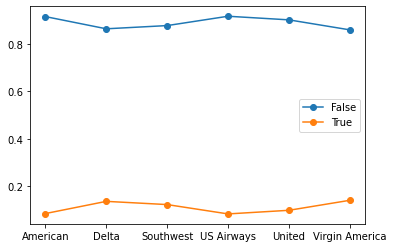

In [97]:
plot_probs('Thank', 'Company', evidence)

Apparently Delta and Virgin America increase the probability of Thank. This does make sense since from [the Problem table](#CP-5) it appears that these two caompanies have an overall high probability of Problems=None.

So let's put Delta in the evidence, the next question is how the Tweet Length influences the probability of Thank. Ideally Tweet Length = Short should maximize it because we've seen that a short tweet should be a sign of a positive/neutral tweet.

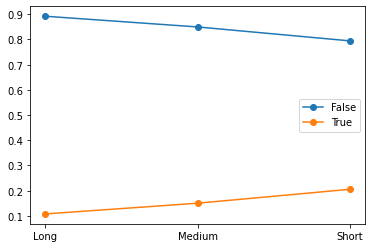

In [98]:
evidence['Company'] = t_d['Company']['Delta']
plot_probs('Thank', 'Tweet Length', evidence)

In fact.

Let's add short to the evidence. How much of an influence does Retweets have on Thank?

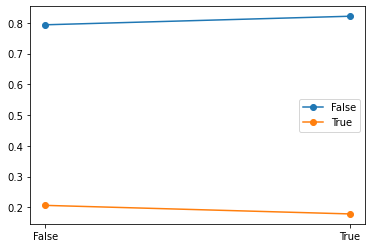

In [99]:
evidence['Tweet Length'] = t_d['Tweet Length']['Short']
plot_probs('Thank', 'Retweets', evidence)

Very low influence. Let's add it to the evidence anyway.

Does Cancelled influences Thank? In theory it should, in particular knowing that Cancelled is False should raise the probability of Thank a bit.

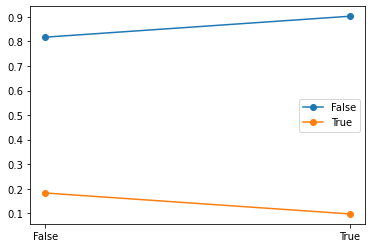

In [100]:
evidence['Retweets'] = t_d['Retweets']['True']
plot_probs('Thank', 'Cancelled', evidence)

Yes, it increases the Thank chances by a very small amount (on the other hand, knowing that Cancelled is True almost nullify the chances of Thank being True)

Does Tweet Time has any effects on Thank? Since Retweets is in the evidence it should.

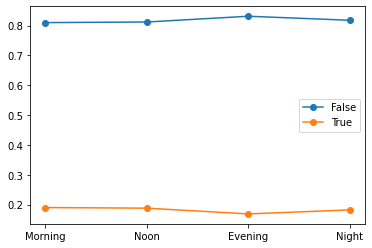

In [101]:
evidence['Cancelled'] = t_d['Cancelled']['False']
plot_probs('Thank', 'Tweet Time', evidence)

Yes it has a very small effect. It makes sense that Tweet Time=Evening lowers the probability of Thank a bit since we've seen [here](#evening) that tweets sent during the evening are more likely to be negative.

Anyway, all this variables seems to have a small amount of influence on the probability of Thank. Let's see how strongly Problems influences it keeping in mind that in this way the contribution of Company, Bad Weather and Strike are nullified.

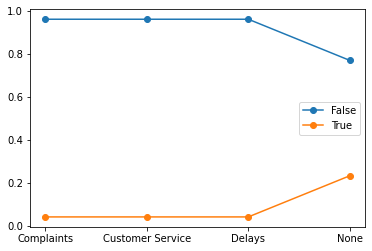

In [102]:
evidence['Tweet Time'] = t_d['Tweet Time']['Morning']
plot_probs('Thank', 'Problems', evidence)

Understandably, Problems has a huge influence on Thank since if Problems it's not None, the sentiment is always going to be negative and this makes the likeliness of Thank almost 0. Meanwhile if Problems is None there are far more chances to have Thank in the tweet.

### 5.3. Sampling <a class="anchor" id="Q-3"></a>

I'd like to spend a small section talking about sampling. Sampling is a technique to obtain the distribution of a variable when it's computationally too expensive to perform exact inference.

#### 5.3.1. The importance of the number of samples <a class="anchor" id="Q-3-1"></a>

Let's try to perform sampling by using the default pgmpy method and let's see by how much the sampled distribution differs from the exact one.

In [103]:
from pgmpy.inference import ApproxInference

airline_app = ApproxInference(airline_model)
evidence = {'City': t_d['City']['New York'], 'Cancelled': t_d['Cancelled']['True']}
app_q=airline_app.query(['Tweet Length'], evidence=evidence)
exact_q=airline_inf.query(['Tweet Length'], evidence=evidence)
print('Sampling distributions:')
print(app_q)
print('Exact Inference Distribution:')
print(exact_q)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Sampling distributions:
+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.6082 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3130 |
+-----------------+---------------------+
| Tweet Length(2) |              0.0788 |
+-----------------+---------------------+
Exact Inference Distribution:
+-----------------+---------------------+
| Tweet Length    |   phi(Tweet Length) |
+=================+=====================+
| Tweet Length(0) |              0.6122 |
+-----------------+---------------------+
| Tweet Length(1) |              0.3075 |
+-----------------+---------------------+
| Tweet Length(2) |              0.0802 |
+-----------------+---------------------+


The two CPDs are very similar.

On the other hand, it must be noted that pgmpy sets the number of samples to 10000 by deafult. While it's indeed  good number of samples, it can be unfeasible in practice to compute 10000 samples due to computation time. It could be interesting to see how similar the CPDs are while varying the number of samples.

The first step to do that is to define a function that compares the two probability distributions. We will take a naive approach, we'll compute the euclidean distance between them and use this value as a dissimilarity measure. In other words:

$Dissimilarity=\sqrt{\sum_{i=1}^{n}(X_{i}^{app}-X_{i}^{exact})^{2}}$

Let's implement it:

In [104]:
def dissimilarity(variable, cpd1, cpd2):
    cardinality = len(t_d[variable].items()) # Cardinality of variable
    dist_1 = []
    dist_2 = []
    for v in t_d[variable].values(): # For each value extract its probability from the cpd
        dist_1.append(cpd1.get_value(**{variable: v}))
        dist_2.append(cpd2.get_value(**{variable: v}))
    return np.linalg.norm(np.array(dist_1)-np.array(dist_2), 2)

Very well, now let's define a function that takes a variable, the evidence and a list as inputs. Then for each value in the list perform a query with exact inference and sampling (using the value from the list as the number of samples) and then plots for each number of samples the dissimilarity and the difference in computation time between the sampling query and the exact inference.

Let's implement it.

In [105]:
import time

def plot_diss_time(var, ev, rg):
    results = [] # Stores dissimilarities
    ti = [] # Stores time difference
    fig, ax1 = plt.subplots(figsize=(10, 10)) # Prepares plot
    ax2 = ax1.twinx() # In the same plot there are two graphs with different y values, the x axis is shared
    
    start = time.time()
    exact_q = airline_inf.query(var, ev, show_progress=False) # The exact inference cpd doesn't change during iterations, let's compute it once
    exact_time = time.time()-start # Store time spent to compute it
    for n in rg:
        start = time.time()
        app_q = airline_app.query(var, n_samples=n, evidence=ev, show_progress=False) # Sampling with n samples
        app_time = time.time()-start # Compute time spent in computation
        ti.append(app_time-exact_time) # Store difference between time of sampling and time of exact inference
        results.append(dissimilarity(var[0], app_q, exact_q)) # Store in results the dissimilarity between the two methods
        print('Computed case with {} samples.'.format(n))
    ax1.plot(rg.astype(str), results, '-o', label='Dissimilarity')
    ax2.plot(rg.astype(str), ti, '-o', color='orange', label='Time')
    ax1.legend(bbox_to_anchor=(0.2, 1))
    ax2.legend()
    plt.show()

Let's test it:

Computed case with 50 samples.
Computed case with 75 samples.
Computed case with 100 samples.
Computed case with 150 samples.
Computed case with 200 samples.
Computed case with 300 samples.
Computed case with 400 samples.
Computed case with 500 samples.
Computed case with 600 samples.
Computed case with 700 samples.
Computed case with 800 samples.
Computed case with 900 samples.
Computed case with 1000 samples.
Computed case with 5000 samples.
Computed case with 10000 samples.
Computed case with 20000 samples.


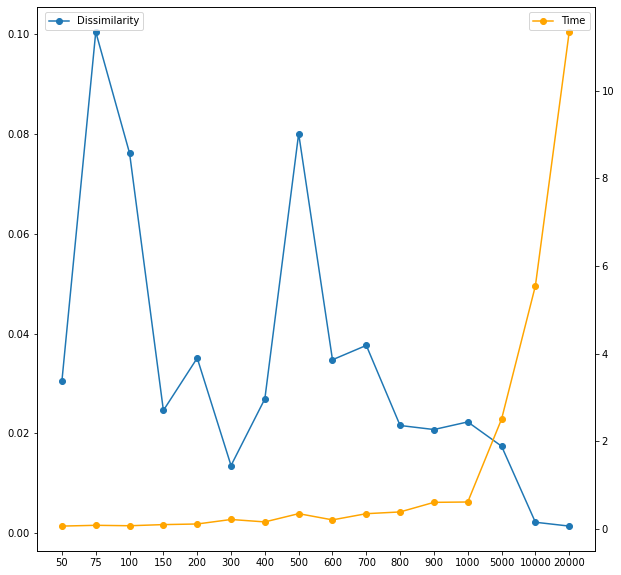

In [106]:
vals = [50, 75, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 5000, 10000, 20000]
plot_diss_time(['Tweet Length'], {'City': t_d['City']['New York'], 'Retweets': t_d['Retweets']['True']}, np.array(vals))

As expected, while the dissimilarity quickly decreases with the number of samples, the computational time grows exponentially.

All to say that even if the sampling method is a good method to obtain the probability distribution of a variable given the evidence, we need to find a good tradeoff between number of samples and approximation's precision. 

### 5.3.2. Variables with low probabilities <a class="anchor" id="Q-3-2"></a>

I was wondering: what kind of sampling method the default pgmpy function uses? On [their website](https://pgmpy.org/approx_infer/approx_infer.html) the query() method has this description:

*Method for doing approximate inference based on sampling in Bayesian Networks and Dynamic Bayesian Networks.*

By itself, it doesn't tell us much about the sampling method used so I jumped to the [implementation](https://pgmpy.org/_modules/pgmpy/inference/ApproxInference.html#ApproxInference.query) of their query to see if I could discover something useful. The method itself doesn't tell us much because the only meaningful thing it does is calling another method:

```python
samples = self.model.simulate(
            n_samples=n_samples,
            evidence=evidence,
            virtual_evidence=virtual_evidence,
            show_progress=show_progress,
        )
```

I then went to check the [implementation of the simulate() method](https://pgmpy.org/_modules/pgmpy/models/BayesianNetwork.html#BayesianNetwork.simulate) to finally find find what I was looking for, in particular:

```python
        # Step 3: If no evidence do a forward sampling
        if len(evidence) == 0:
            samples = BayesianModelSampling(model).forward_sample(
                size=n_samples,
                include_latents=include_latents,
                seed=seed,
                show_progress=show_progress,
                partial_samples=partial_samples,
            )

        # Step 4: If evidence; do a rejection sampling
        else:
            samples = BayesianModelSampling(model).rejection_sample(
                size=n_samples,
                evidence=[(k, v) for k, v in evidence.items()],
                include_latents=include_latents,
                seed=seed,
                show_progress=show_progress,
                partial_samples=partial_samples,
            )
```

So if no evidence is provided the sampling is performed with forward sampling, otherwise rejection sampling is used.

Rejection sampling works this way: for each node in the network randomly assign it a value. If the node wasn't in the evidence go on, if the node was in the evidence and the value I just assigned to it is in contradiction with the evidence discard the sample. This means that if a value in the evidence has a low probability of happening the computation time increases! Let's test this theory by plotting the time spent in computation by a sampling operation with an evidence with __Strike=False__ (0.99) and one with __Strike=True__ (0.01).

Computed sampling with 50 samples.
Computed sampling with 100 samples.
Computed sampling with 200 samples.
Computed sampling with 500 samples.
Computed sampling with 800 samples.
Computed sampling with 1000 samples.
Computed sampling with 2000 samples.


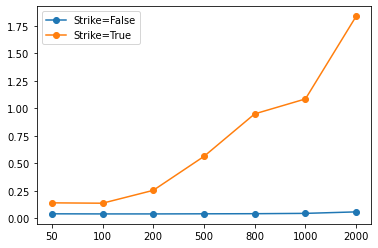

In [107]:
no_strike = [] # Time with evidence with strike=False
strike = [] # Time with evidence with strike=True
ev_s = {'Strike': t_d['Strike']['True']}
ev_ns = {'Strike': t_d['Strike']['False']}
samples = np.array([50, 100, 200, 500, 800, 1000, 2000])
for n in samples:
    start = time.time()
    airline_app.query(['Sentiment'], n_samples=n, evidence=ev_s, show_progress=False) # Sampling with Strike=True
    strike.append(time.time()-start) # Store time
    start = time.time()
    airline_app.query(['Sentiment'], n_samples=n, evidence=ev_ns, show_progress=False) # Sampling with StrikeFalse
    no_strike.append(time.time()-start) # Store time
    print('Computed sampling with {} samples.'.format(n))
plt.plot(samples.astype(str), no_strike, '-o', label='Strike=False') # Plot
plt.plot(samples.astype(str), strike, '-o', label='Strike=True')
plt.legend()
plt.show()

I'd say that the results speak for themselves.


This is one of the weak points of rejection sampling and should be taken in consideration when performing sampling.

### 5.4. The Network as a Classifier <a class="anchor" id="Q-4"></a>

I thought it could be interesting to try to use the network as a classifier to label __Sentiment__ and __Problems__. The algorithm should work as follows:
- There will be a function __extract_features__ that, given a row of the dataset, will extract __Thank__, __Cancelled__, __Flight__, __Retweets__, __Tweet Time__, __Tweet Length__ and __Company__. __Strike__, __City__ and __Bad Weather__ are not added because I invented the values, so i cannot extract them from the dataset. Meanwhile __Confidence__ is not in the evidence because it isn't in the __Markov Blanket__ of both Sentiment and Problems (given the evidence).
- The extracted values are added to the evidence
- The network is queried with \[\'Sentiment\', \'Problems\'\] and the pair with higher probability value is picked
- The choosen pair is compared with the ground truth

Before starting, a little disclaimer: I didn't query just Sentiment or Problems alone because they are too strongly correlated, if the network knows that Problems for example is not None, then will always guess correctly the sentiment.

Let's start with the extract_features function:

In [108]:
def extract_features(row_dict):
    evidence = {} 
    
    # Extract from the fields of the datum the features we need
    
    evidence['Company'] = t_d['Company'][row_dict['airline']]
    evidence['Retweets'] = t_d['Retweets'][row_dict['retweet_count']]
    evidence['Tweet Length'] = t_d['Tweet Length'][row_dict['tweet_length']]
    evidence['Tweet Time'] = t_d['Tweet Time'][row_dict['tweet_created']]
    
    # Search in the text field our "keywords"
    
    for word in ['Thank', 'Flight', 'Cancelled']:
        if word.lower() in row_dict['text'].lower():
            evidence[word] = t_d[word]['True']
        else:
            evidence[word] = t_d[word]['False']
            
    # Dict to convert Sentiment and Problems into 0, 1, etc
    
    conv_dict = {'Sentiment': {
                    'negative': 0,
                    'neutral': 1,
                    'positive': 2
                },
                 'Problems': {
                     'Complaints': 0,
                     'Customer Service': 1,
                     'Delay': 2,
                     'None': 3
                 }
            }
    
    # Ground truth
    
    truth = {
        'Sentiment': conv_dict['Sentiment'][row_dict['airline_sentiment']],
        'Problems': conv_dict['Problems'][row_dict['negativereason']]
    }
    return evidence, truth

__classify__ works in this way:
- Takes as input an integer n.
- Extracts from the dataset n random samples.
- Extract evidence from each one of them.
- Classifies them.
- Returns a triplet of the form (#correct_guesses_sentiment. #correct_guesses_problems, #correct_guesses_both)

In [109]:
import itertools

def classify(n):
    rows = random.sample(tweet_df.to_dict(orient='records'), n) # n dictionaries. Each dictionary is a row of the dataset
    possible_vals = list(itertools.product((0, 1, 2), (0, 1, 2, 3))) # Combination of all the possible values for (sentiment, problems)
    correct = [0, 0, 0] # Number of correct guesses for (Sentiment, Problems, Both)
    for row in rows:
        ev, truth = extract_features(row) # Extract features
        query = airline_inf.query(['Sentiment', 'Problems'], ev, show_progress=False) # Run query
        max_val = ((-1, -1), 0) # Stores maximum value. ((sentiment_value, problems_value), probability)
        for pair in possible_vals: # Find maximum value by examining all possible combinations
            prob = query.get_value(**{'Sentiment': pair[0], 'Problems': pair[1]})
            if prob >= max_val[1]:
                max_val = (pair, prob)
        
        # Update correct accordingly
        
        if max_val[0][0] == truth['Sentiment'] and max_val[0][1] == truth['Problems']:
            correct[0] += 1
            correct[1] += 1
            correct[2] += 1
        elif max_val[0][0] == truth['Sentiment']:
            correct[0] += 1
        elif max_val[0][1] == truth['Problems']:
            correct[1] += 1
    return correct

Lastly __plot_accuracy__:
- Takes as input n_experiments, b_size
- For each experiments in n_experiments:
    - Calls classify(b_size)
    - Stores results
    - Plots results

In [110]:
def plot_accuracy(n_experiments, b_size):
    sentiment_results = [] # Will contain results for each category
    problems_results = []
    both_results = []
    for exp in range(n_experiments):
        results = classify(b_size) # Classify
        sentiment_results.append(results[0]/b_size) # Stores results
        problems_results.append(results[1]/b_size)
        both_results.append(results[2]/b_size)
        print('Completed experiment {}.'.format(exp+1))
    plt.plot(sentiment_results, label='Sentiment')
    plt.axhline(np.mean(sentiment_results), color='r', linestyle='--') # Plots the results
    plt.plot(problems_results, label='Problems')
    plt.axhline(np.mean(problems_results), color='r', linestyle='--')
    plt.plot(both_results, label='Both')
    plt.axhline(np.mean(both_results), color='r', linestyle='--')
    plt.legend()
    plt.show()

We are finally ready to call __plot_accuracy__ and see what are the results!

Completed experiment 1.
Completed experiment 2.
Completed experiment 3.
Completed experiment 4.
Completed experiment 5.


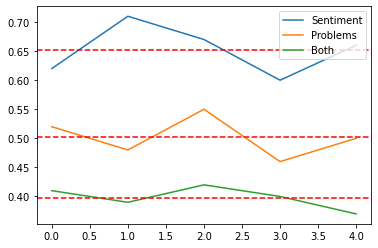

In [111]:
plot_accuracy(5, 100)

Sadly the results are not as good as I hoped. 

The Sentiment's accuracy is the only one barely acceptable with an average above 0.6.

The Problem's accuracy shows an average barely bigger than 0.5, not good.

Lastly the accuracy for both classifications to be correct is below 0.5. Again, not that good.

Anyway no matter the results it was a fun thing to test out, maybe with a different network structure or with more features the results could improve! 

## 6. Conclusions <a class="anchor" id="C"></a>

It was interesting to extract data from a real world dataset and try to develop a Bayesian Network on top of it. My Network is far from being perfect, but I think in most of the occasions behaved asI was expecting it to do. Some things to notice:

- The interaction between Sentiment and Problem shut down most query possiblities because knowing one of the two has __heavy__ implications on the cpd of the other.
- The structure of the network is a bit "vertical". By this I mean that having Problems or Sentiment in the evidence shields half of the network away from the query limiting the query possibilities
- Sadly some nodes didn't turn out to be as interesting as I hoped, for example Retweets and Tweet Time didn't have that much of an effect in most of the queries, probably because they weren't as correlated as I hoped with the rest of the network.
- Also Confidence didn't have as much correlation as I hoped with the three word I chose.

The results obtained in the sampling part behaved as I expected also because they don't really depend much on the structure of the network.

The experiment with the classifier didn't go as well as I hoped. I'm sure that querying only one one of Sentiment or Problems will produce largely better results. Probably the results weren't as good because the variable in the net weren't sufficient to discriminate between the various problems and sentiments. Let's keep in mind that this process should exploit Natural Language Processing to work at best, while the Network just searches for 3 specific words to make assumptions about the __content__ of the tweet.

Anyway it was a fun and interesting experience, also a useful one because I learnt how to use a library that I didn't know about.